In [21]:
from google.colab import files
upload = files.upload()

Saving Final_Data.xlsx to Final_Data.xlsx


In [1]:
import io
import pandas as pd

data = pd.read_excel('Final_Data.xlsx')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import eli5
from eli5.sklearn import PermutationImportance
import shap
from sklearn.tree import DecisionTreeRegressor

In [3]:
def plot_predictions_vs_actual(y_test, predictions, model_name):
    y_test = y_test.reset_index(drop=True)

    sorted_indices = np.argsort(y_test)
    sorted_y_test = y_test.iloc[sorted_indices].reset_index(drop=True)
    sorted_predictions = predictions[sorted_indices]

    plt.figure(figsize=(14, 7))
    plt.scatter(range(len(sorted_y_test)), sorted_y_test, color='red', label='Actual', alpha=0.6)
    plt.scatter(range(len(sorted_predictions)), sorted_predictions, color='blue', label='Predicted', alpha=0.6)
    plt.title(f'{model_name}: Actual vs Predicted Birth Rates')
    plt.xlabel('Samples')
    plt.ylabel('Fertility Rate')
    plt.legend()
    plt.show()

In [5]:
train = data[data['Year'] <= 2015]
valid = data[(data['Year'] > 2015) & (data['Year'] <= 2018)]
test = data[data['Year'] > 2018]

X_train = train.drop(['FertilityRate', 'Year'], axis=1)
y_train = train['FertilityRate']

X_valid = valid.drop(['FertilityRate', 'Year'], axis=1)
y_valid = valid['FertilityRate']

X_test = test.drop(['FertilityRate', 'Year'], axis=1)
y_test = test['FertilityRate']

X_train_valid = pd.concat([X_train, X_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)

-------------Best Hyperparameter------------
Best hyperparameters: n_estimators              100
max_depth                  20
min_samples_split           2
min_samples_leaf            1
MSE_train            0.000456
MSE_valid            0.018167
Name: 18, dtype: object
-------------Model Evaluation------------
  Metric  Test Set Performance
0    MSE              0.028746
1     R2              0.276193
2    MAE              0.121922


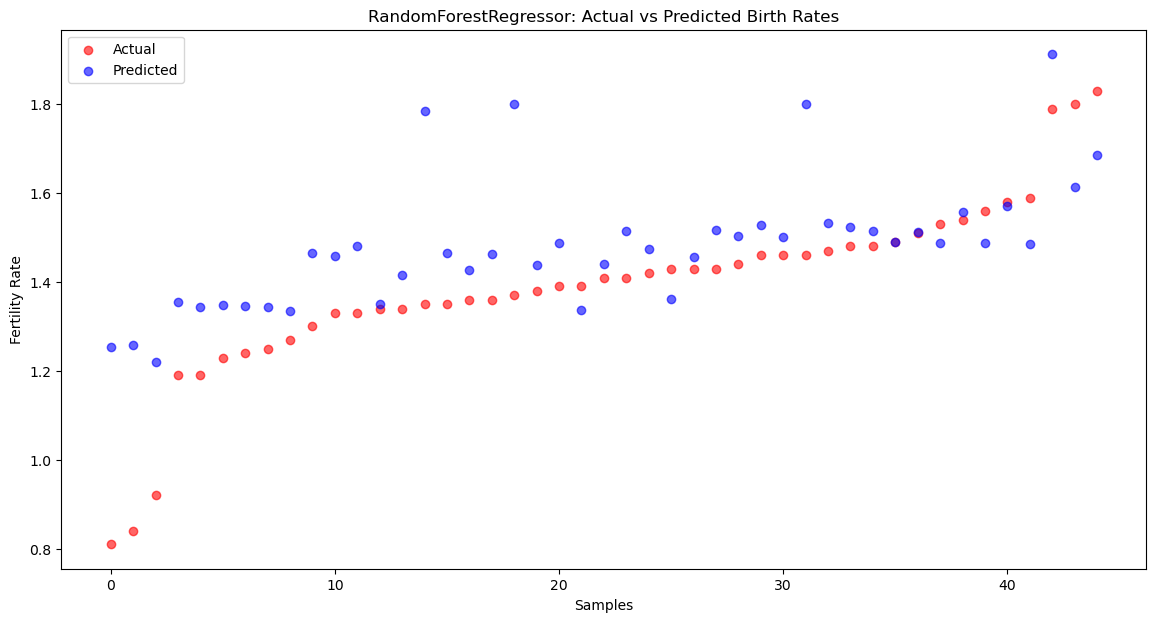

In [13]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

results_df = pd.DataFrame(columns=["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "MSE_train", "MSE_valid"])

for n_estimators in param_grid_rf['n_estimators']:
    for max_depth in param_grid_rf['max_depth']:
        for min_samples_split in param_grid_rf['min_samples_split']:
            for min_samples_leaf in param_grid_rf['min_samples_leaf']:
                model = RandomForestRegressor(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              min_samples_leaf=min_samples_leaf,
                                              random_state=0)
                model.fit(X_train, y_train)
                predictions_train = model.predict(X_train)
                predictions_valid = model.predict(X_valid)
                mse_train = mean_squared_error(y_train, predictions_train)
                mse_valid = mean_squared_error(y_valid, predictions_valid)

                temp_df = pd.DataFrame({
                    "n_estimators": [n_estimators],
                    "max_depth": [max_depth],
                    "min_samples_split": [min_samples_split],
                    "min_samples_leaf": [min_samples_leaf],
                    "MSE_train": [mse_train],
                    "MSE_valid": [mse_valid]
                })

                results_df = pd.concat([results_df, temp_df], ignore_index=True)

best_hyperparams = results_df.loc[results_df["MSE_valid"].idxmin()]
print("-------------Best Hyperparameter------------")
print('Best hyperparameters:', best_hyperparams)

best_model = RandomForestRegressor(n_estimators=int(best_hyperparams["n_estimators"]),
                                   max_depth=best_hyperparams["max_depth"],
                                   min_samples_split=int(best_hyperparams["min_samples_split"]),
                                   min_samples_leaf=int(best_hyperparams["min_samples_leaf"]),
                                   random_state=0)
best_model.fit(X_train_valid, y_train_valid)
predictions_test = best_model.predict(X_test)

mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)
mae_test = mean_absolute_error(y_test, predictions_test)

performance_df_rf = pd.DataFrame({
    "Metric": ["MSE", "R2", "MAE"],
    "Test Set Performance": [mse_test, r2_test, mae_test]
})

print("-------------Model Evaluation------------")
print(performance_df_rf)

plot_predictions_vs_actual(y_test, predictions_test,"RandomForestRegressor")

-------------Best Hyperparameter------------
Best hyperparameters for XGBRegressor: n_estimators          300
max_depth               3
learning_rate         0.1
MSE_train        0.000128
MSE_valid        0.015037
Name: 19, dtype: object
-------------Model Evaluation------------
  Metric  Test Set Performance
0    MSE              0.012142
1     R2              0.694262
2    MAE              0.089414


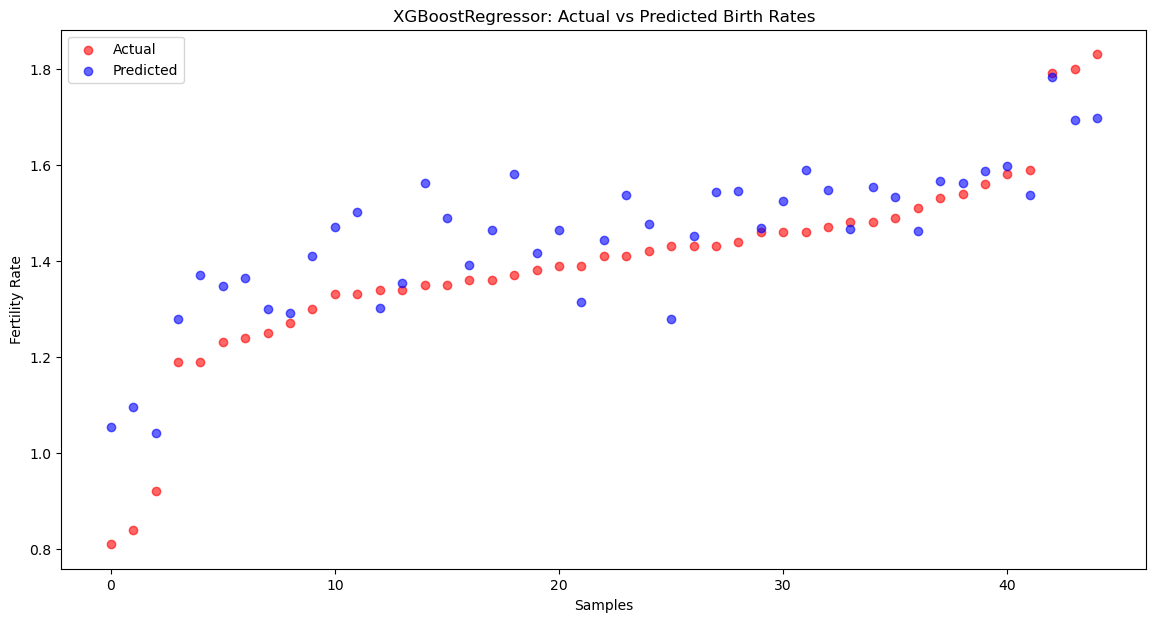

In [16]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

results_df_xgb = pd.DataFrame(columns=["n_estimators", "max_depth", "learning_rate", "MSE_train", "MSE_valid"])

for n_estimators in param_grid_xgb['n_estimators']:
    for max_depth in param_grid_xgb['max_depth']:
        for learning_rate in param_grid_xgb['learning_rate']:
          model = XGBRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               learning_rate=learning_rate,
                               random_state=0)
          model.fit(X_train, y_train)
          predictions_train = model.predict(X_train)
          predictions_valid = model.predict(X_valid)
          mse_train = mean_squared_error(y_train, predictions_train)
          mse_valid = mean_squared_error(y_valid, predictions_valid)
          temp_df_xgb = pd.DataFrame({
                        "n_estimators": [n_estimators],
                        "max_depth": [max_depth],
                        "learning_rate": [learning_rate],
                        "MSE_train": [mse_train],
                        "MSE_valid": [mse_valid]
                    })
          results_df_xgb = pd.concat([results_df_xgb, temp_df_xgb], ignore_index=True)

best_hyperparams_xgb = results_df_xgb.loc[results_df_xgb["MSE_valid"].idxmin()]

print("-------------Best Hyperparameter------------")
print('Best hyperparameters for XGBRegressor:', best_hyperparams_xgb)

best_model_xgb = XGBRegressor(n_estimators=int(best_hyperparams_xgb["n_estimators"]),
                              max_depth=int(best_hyperparams_xgb["max_depth"]),
                              learning_rate=best_hyperparams_xgb["learning_rate"],
                              random_state=0)
best_model_xgb.fit(X_train_valid, y_train_valid)
predictions_test_xgb = best_model_xgb.predict(X_test)

mse_test_xgb = mean_squared_error(y_test, predictions_test_xgb)
r2_test_xgb = r2_score(y_test, predictions_test_xgb)
mae_test_xgb = mean_absolute_error(y_test, predictions_test_xgb)

performance_df_xgb = pd.DataFrame({
    "Metric": ["MSE", "R2", "MAE"],
    "Test Set Performance": [mse_test_xgb, r2_test_xgb, mae_test_xgb]
})

print("-------------Model Evaluation------------")
print(performance_df_xgb)

plot_predictions_vs_actual(y_test, predictions_test_xgb,"XGBoostRegressor")

-------------Best Hyperparameter------------
Best hyperparameters for DecisionTreeRegressor: max_depth                  10
min_samples_split           2
min_samples_leaf            4
MSE_train            0.001155
MSE_valid            0.043165
Name: 2, dtype: object
-------------Model Evaluation------------
  Metric  Test Set Performance
0    MSE              0.051499
1     R2             -0.296713
2    MAE              0.160888


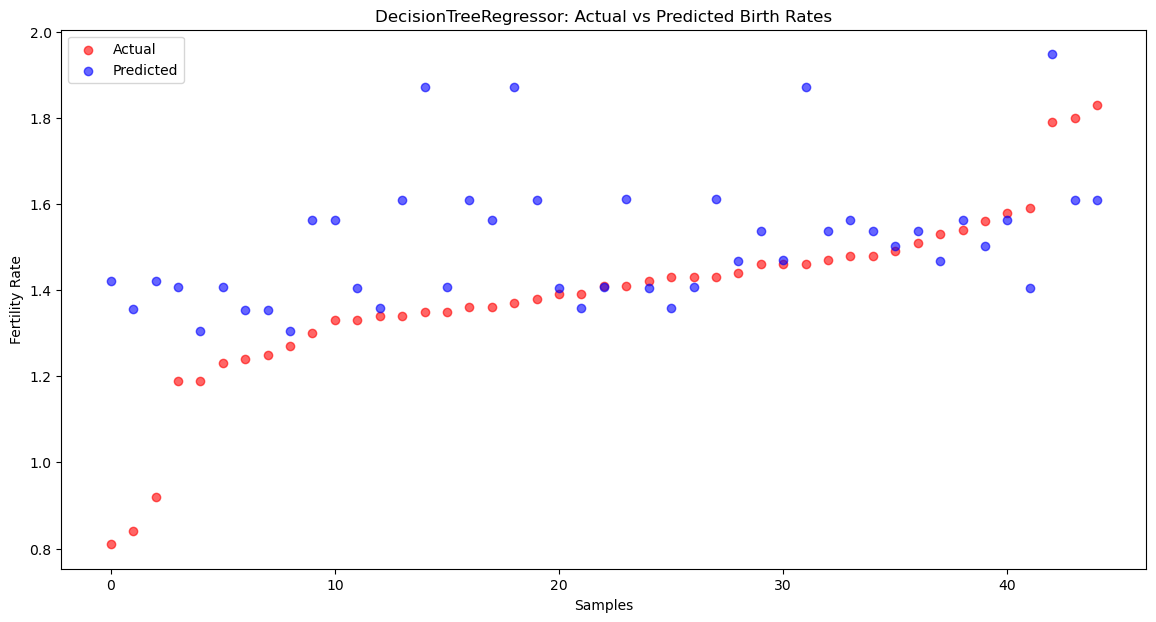

In [17]:
param_grid_dt = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

results_df_dt = pd.DataFrame(columns=["max_depth", "min_samples_split", "min_samples_leaf", "MSE_train", "MSE_valid"])

for max_depth in param_grid_dt['max_depth']:
    for min_samples_split in param_grid_dt['min_samples_split']:
        for min_samples_leaf in param_grid_dt['min_samples_leaf']:
            model = DecisionTreeRegressor(max_depth=max_depth,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=0)
            model.fit(X_train, y_train)
            predictions_train = model.predict(X_train)
            predictions_valid = model.predict(X_valid)
            mse_train = mean_squared_error(y_train, predictions_train)
            mse_valid = mean_squared_error(y_valid, predictions_valid)

            temp_df_dt = pd.DataFrame({
                "max_depth": [max_depth],
                "min_samples_split": [min_samples_split],
                "min_samples_leaf": [min_samples_leaf],
                "MSE_train": [mse_train],
                "MSE_valid": [mse_valid]
            })

            results_df_dt = pd.concat([results_df_dt, temp_df_dt], ignore_index=True)

best_hyperparams_dt = results_df_dt.loc[results_df_dt["MSE_valid"].idxmin()]
print("-------------Best Hyperparameter------------")
print('Best hyperparameters for DecisionTreeRegressor:', best_hyperparams_dt)

best_model_dt = DecisionTreeRegressor(max_depth=best_hyperparams_dt["max_depth"],
                                      min_samples_split=int(best_hyperparams_dt["min_samples_split"]),
                                      min_samples_leaf=int(best_hyperparams_dt["min_samples_leaf"]),
                                      random_state=0)
best_model_dt.fit(X_train_valid, y_train_valid)
predictions_test_dt = best_model_dt.predict(X_test)

mse_test_dt = mean_squared_error(y_test, predictions_test_dt)
r2_test_dt = r2_score(y_test, predictions_test_dt)
mae_test_dt = mean_absolute_error(y_test, predictions_test_dt)

performance_df_dt = pd.DataFrame({
    "Metric": ["MSE", "R2", "MAE"],
    "Test Set Performance": [mse_test_dt, r2_test_dt, mae_test_dt]
})
print("-------------Model Evaluation------------")
print(performance_df_dt)

plot_predictions_vs_actual(y_test, predictions_test_dt,"DecisionTreeRegressor")


In [18]:
perm = PermutationImportance(best_model_xgb, random_state=0).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3753 ± 0.1759,FirstBirthAge
0.0915 ± 0.0427,FamilyExpenditure
0.0867 ± 0.0269,FemaleLaborParticipationRate
0.0807 ± 0.0852,UnemploymentExpenditure
0.0727 ± 0.0466,GDI
0.0530 ± 0.0295,HousingAffordabilityIndex
0.0493 ± 0.0190,EmploymentRate
0.0355 ± 0.0310,HousingPrice
0.0284 ± 0.0210,TotalLaborParticipationRate
0.0160 ± 0.0340,AvgHoursWorked


[14:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


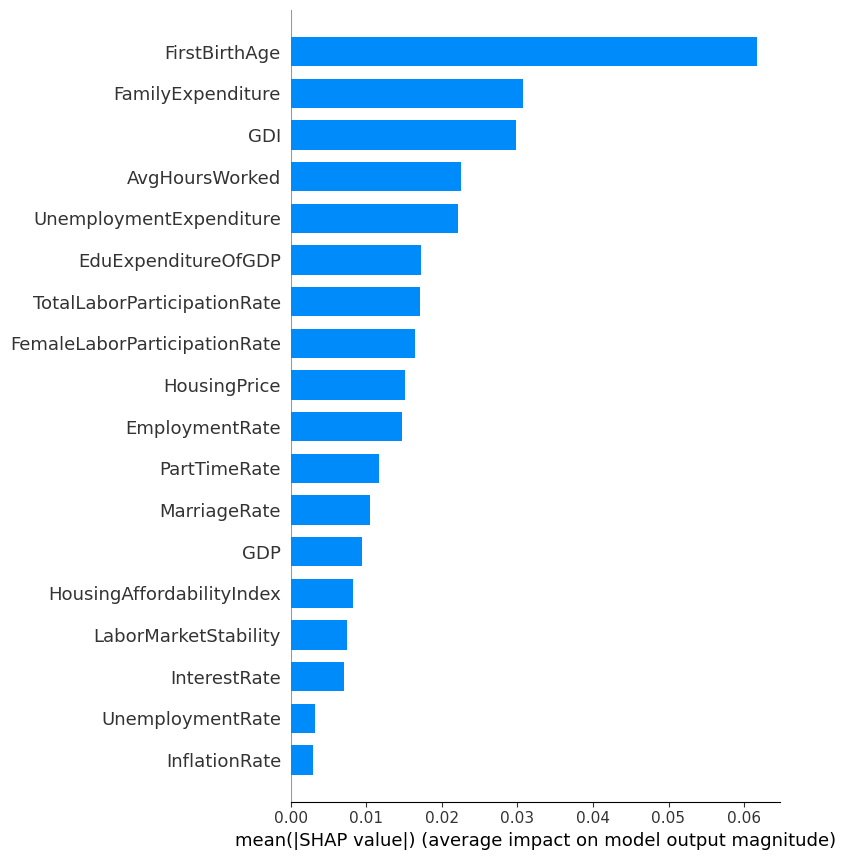

In [19]:
explainer = shap.TreeExplainer(best_model_xgb)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


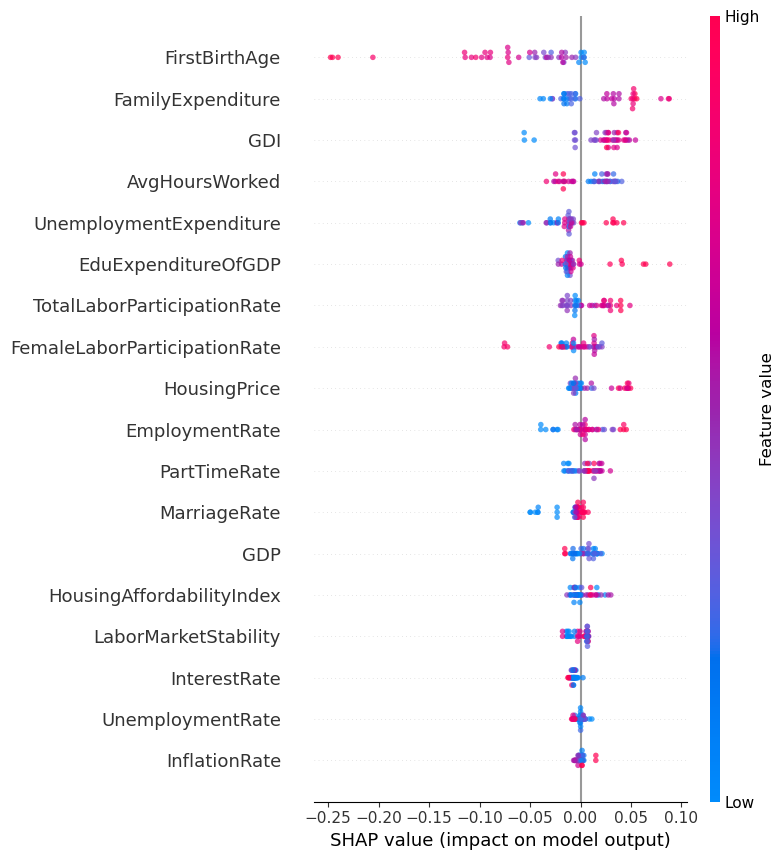

In [20]:
shap.summary_plot(shap_values, X_test, alpha=0.7)